# Explainable like I'm 5 (ELI5)

**설명 변수의 중요도**는 모델을 해석하고 진단하는데 유용한 explainer이다.<br>
선형 회귀 모델의 회귀 계수, 의사결정나무의 불순도 지수로부터 구한 information gain의 크기가 해당된다.

**ELI5**는 sklearn에서 제공하는 머신러닝 모델들의 설명 가능성을 제공하는 라이브러리이다.<br>
sklearn에서 제공하는 모델의 global 및 local explainer를 제공한다.<br>
❗주의사항: ELI5의 Permutation Importance는 bias되어 있어, 성능이 나쁜 모델에서 낮은 중요도를 가진 설명 변수가 성능이 좋은 모델에서는 높은 중요도를 보이는 경우가 발생한다. (Breiman(2001))

다음 코드는 다양한 모델에 대하여 ELI5를 적용하는 실습 예제이다.

`ColumnTransformers`: 설명 변수가 범주형 또는 문자형일 떄 one-hot-encoding 또는 실수형 데이터로 전환<br>
`balanced-accuracy-score`: 분류 task에서 범주별 recall의 평균 반환

In [1]:
# Data Handler
import numpy as np
import pandas as pd

# Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# eXplainable AI
import eli5

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

포르투갈의 은행의 정기예금 marketing 데이터를 불러온다.<br>
고객에 대한 설명 변수로 텔레마케팅 성공 여부를 예측하는 이진 분류 task이다.

In [2]:
df = pd.read_csv("./data/bank.csv")
print(df.shape)
df.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


다음과 같이 종속 변수에 대하여 불균형한 데이터임을 확인할 수 있다.

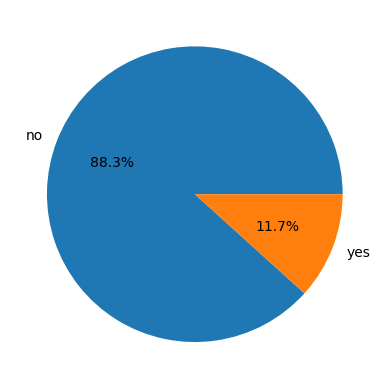

In [3]:
ratio = df['y'].value_counts().to_list()
labels = df['y'].value_counts().index.to_list()

plt.pie(ratio, labels=labels, autopct="%.1f%%")
plt.show()

종속 변수를 `y`변수에 할당한다. 이 때, 마케팅 성공을 나타내는 `yes`를 1로 실패를 나타내는 `no`를 0으로 변경하여 할당한다.<br>
설명 변수의 경우 `X`변수에 할당한다.

In [ ]:
y = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns = 'y', inplace = False).copy()
print(f"y: {y.shape}, {type(y)}")
print(f"X: {X.shape}, {type(X)}")

y: (45211,), <class 'pandas.core.series.Series'>
X: (45211, 16), <class 'pandas.core.frame.DataFrame'>


훈련 데이터와 시험데이터를 분리한다.<br>
불균형 데이터이므로 `stratify` 매개변수에 종속 변수 데이터를 전달하여 target 비율을 유지한다.<br>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

`ColumnTransformer`를 적용하기 위해 종속 변수에 대하여 수치형 변수와 범주형 변수명을 각각 `num_features`, `cat_features`로 정의한다.

In [6]:
num_features = []
cat_features = []

for col in X.columns:
    if X[col].dtype == 'O':
        cat_features.append(col)
    else:
        num_features.append(col)
print(f"num_features: {num_features}")
print(f"cat_features: {cat_features}")

num_features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


`ColumnTransformer`를 `preprocessor`로 객체화한다.<br>
데이터변환의 형태에 따라 `(name, transformer 함수, columns names)`의 리스트 형태로 설명 변수를 변환한다.<br>
`name` 매개변수는 컬럼 집합에 대한 이름을 선언한다.<br>
`transformer 함수`에는 다음 문자열을 전달할 수 있다.<br>
    - `"drop"`: 해당 컬럼 삭제<br>
    - `"passthrough"`: 변환을 하지 않음<br>
<a href=https://scikit-learn.org/1.5/modules/generated/sklearn.compose.ColumnTransformer.html target="_blank">ColumnTransformer API Docs</a>


`OneHotEncoder`<br>
    - `sprase_output`: `boolean`, `True`인 경우 Compressed Sparse Row (CSR) 형식의 행렬 반환<br>
    - `hanlde_unknown`: `transform` 메서드 적용 시 `fit`메서드를 통해 학습한 카테고리가 없을 때의 동작 설정<br>
<a href="https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.OneHotEncoder.html" target="_blank">OneHotEncoder API Docs</a>


In [7]:
prerpocessor = ColumnTransformer([
    ("numerical", "passthrough", num_features),
    ("categorical", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_features)
])

설명 변수에 대하여 ColumnTransformer를 학습시킨다.

In [ ]:
prerpocessor.fit(X_train)

범주형 변수에 대한 학습 결과를 확인한다.

In [9]:
ohe_categories = prerpocessor.named_transformers_['categorical'].categories_
ohe_categories

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object),
 array(['divorced', 'married', 'single'], dtype=object),
 array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['cellular', 'telephone', 'unknown'], dtype=object),
 array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
        'nov', 'oct', 'sep'], dtype=object),
 array(['failure', 'other', 'success', 'unknown'], dtype=object)]

해석 단계에서 변수 구별을 위해 `설명 변수명_카테고리`형태의 리스트를 생성한다.<br>
ex) `job_admin.`, `job_blue_collar`, ... `poutcome_succes`, `poutcome_unknown`

In [10]:
new_ohe_categories = []

for col, vals in zip(cat_features, ohe_categories):
    for val in vals:
        new_ohe_categories.append(f"{col}_{val}")
print(new_ohe_categories)

['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


수치형 변수명 리스트와 생성한 리스트를 합치고, 변환된 데이터프레임의 변수명으로 선언한다.

In [11]:
all_features = num_features + new_ohe_categories

X_train_transformed = pd.DataFrame(
    prerpocessor.transform(X_train),
    columns = all_features
)
X_test_transformed = pd.DataFrame(
    prerpocessor.transform(X_test),
    columns = all_features
)
X_train_transformed.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,31.0,1.0,9.0,82.0,1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,35.0,195.0,17.0,203.0,1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,24.0,77.0,16.0,236.0,2.0,-1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,35.0,80.0,2.0,579.0,2.0,-1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,37.0,105.0,21.0,197.0,2.0,157.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


모델을 선언한다.<br>
이 떄, 종속 변수의 불균형 문제를 고려하기 위해 `class_weight`매개변수에 `"balanced"`값을 전달한다.<br>
`class_weight`<br>
    - `None`: 기본값, 모든 학습 샘플에 대하여 같은 가중치인 1을 부여<br>
    - `"balanced"`: 종속 변수의 클래스 빈도수 비율의 반비례한 가중치 부여<br>
<a href="https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html" target="_blank">LogisticRegression API Docs</a>,
<a href="https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html" target="_blank">DecisionTreeClassifier API Docs</a>,
<a href="https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html" target="_blank">RandomForestClassifier API Docs</a>,
<a href="https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMClassifier.html" target="_blank">LGBMClassifier API Docs</a>,
<a href="https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier" target="_blank">XGBClassifier API Docs</a>

In [12]:
SEED = 42
lr_model = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=SEED)
dt_model = DecisionTreeClassifier(class_weight="balanced", max_depth=10, min_samples_split=0.05, random_state=SEED)
rf_model = RandomForestClassifier(class_weight="balanced", max_depth=10, min_samples_split=0.05, random_state=SEED, n_jobs=-1)
lgb_model = LGBMClassifier(class_weight="balanced", max_depth=12, min_child_samples=60, n_estimators=50, random_state=SEED, n_jobs=-1, verbosity=0)
xgb_model = XGBClassifier(class_weight="balanced", max_depth=10, min_sample_split=0.05, random_state=SEED, n_jobs=-1, verbosity=0)

선언한 모델들들을 훈련데이터에 대해 학습한다.

In [25]:
lr_model.fit(X_train_transformed, y_train)
dt_model.fit(X_train_transformed, y_train)
rf_model.fit(X_train_transformed, y_train)
lgb_model.fit(X_train_transformed, y_train)
xgb_model.fit(X_train_transformed, y_train)

학습된 모델들로 시험데이터의 성능을 `balanced_accuracy_score`로 평가한다.

In [14]:
y_pred_lr = lr_model.predict(X_test_transformed)
y_pred_dt = dt_model.predict(X_test_transformed)
y_pred_rf = rf_model.predict(X_test_transformed)
y_pred_lgb = lgb_model.predict(X_test_transformed)
y_pred_xgb = xgb_model.predict(X_test_transformed)

print(f"{'Logistic Regression': >20}:", balanced_accuracy_score(y_test, y_pred_lr))
print(f"{'Decision Tree': >20}:", balanced_accuracy_score(y_test, y_pred_dt))
print(f"{'Random Forest': >20}:", balanced_accuracy_score(y_test, y_pred_rf))
print(f"{'LightGBM': >20}:", balanced_accuracy_score(y_test, y_pred_lgb))
print(f"{'XGBoost': >20}:", balanced_accuracy_score(y_test, y_pred_xgb))

 Logistic Regression: 0.8305239158502652
       Decision Tree: 0.8279724491896593
       Random Forest: 0.8359428297221008
            LightGBM: 0.8611232335195704
             XGBoost: 0.7176648016659108


---

### ● Global Explainer

다음 출력은 적합된 Logistic 회귀모델의 회귀계수로 이 계수의 절댓값이 설명 변수의 중요도가 된다.

In [15]:
lr_model.coef_[0]

array([-1.42541219e-03,  2.50480922e-05,  5.82016793e-03,  5.89976090e-03,
       -8.74794315e-02,  5.61519846e-05,  3.38397131e-02,  1.64556769e-01,
       -2.68134855e-01, -2.55471693e-01, -3.73714538e-01, -2.60108699e-02,
        5.22504264e-01, -3.15242540e-01, -1.74287722e-01,  6.86403881e-01,
       -8.54559413e-02, -1.42016909e-01, -1.21844930e-01, -1.30443263e-01,
       -3.02948718e-01,  4.46768988e-02, -3.67507663e-01, -1.02541291e-01,
        1.34571834e-01, -5.32379617e-02, -1.59520733e-01, -2.29194349e-01,
        1.78118121e-01, -5.66833203e-01,  8.54344384e-02, -4.74149520e-01,
        4.15713925e-01,  4.11871198e-01, -1.21630020e+00,  2.37063091e-02,
       -9.26424279e-01,  5.29141916e-01, -3.11783211e-02, -1.20516914e+00,
       -1.07326780e+00,  2.62919167e-01,  1.59363952e+00, -7.61732801e-01,
       -9.95671783e-01,  1.30577089e+00,  8.89551235e-01, -7.44720831e-01,
       -5.14255766e-01,  1.73610025e+00, -8.65838740e-01])

다음은 eli5.show_weights를 통해 Logistic 회귀모델으로 계산된 설명 변수의 중요도이다.<br>
유리박스 모델의 설명 변수의 중요도는 회귀계수이다.<br>
유리박스 모델에 해당하는 모델은 선형회귀, 로지스틱 회귀, 선형 SVM 등이 있다.<br>
아래의 show_weights 함수의 출력은 정렬을 제외하고 위의 회귀계수와 동일한 것을 확인할 수 있다.

<a href="https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights" target="_blank">eli5.show_weights API Docs</a>

In [16]:
eli5.show_weights(lr_model, feature_names=all_features, show=['targets'])

다음은 의사결정나무에 대한 show_weights 출력 결과이다.<br>
의사결정나무 기반의 모든 앙상블기반 모델은 information gain으로 설명 변수 중요도를 정의한다.<br>
information gain은 각 분기별 감소되는 손실값에 분할된 관측치 수를 곱하여 계산한다.<br>
설명 변수가 2개 이상의 노드 분할에 관여할 경우 information gain을 가중평균하여 설명 변수 중요도를 계산한다.

In [17]:
eli5.show_weights(dt_model, feature_names=all_features, show=['feature_importances'])

Weight,Feature
0.5224,duration
0.1596,poutcome_success
0.1035,contact_unknown
0.0663,housing_yes
0.0227,month_aug
0.0224,month_oct
0.0212,month_mar
0.0195,month_jul
0.0111,day
0.0096,loan_yes


다음은 Random Forest에 대한 show_weights 출력 결과이다.<br>
각 의사결정나무(estimator)의 설명 변수별 information gain을 평균하여 설명 변수 중요도를 계산한다.<br>
Random Forest 모델은 2개 이상의 bootstrap 데이터를 사용하므로 설명 변수 중요도의 평균과 표준편차를 계산할 수 있다.

In [18]:
eli5.show_weights(rf_model, feature_names=all_features, show=['feature_importances'])

Weight,Feature
0.4621 ± 0.3070,duration
0.0765 ± 0.1662,poutcome_success
0.0576 ± 0.1514,contact_unknown
0.0456 ± 0.1150,contact_cellular
0.0362 ± 0.0828,housing_yes
0.0338 ± 0.1163,poutcome_unknown
0.0323 ± 0.0998,pdays
0.0320 ± 0.0837,housing_no
0.0289 ± 0.1033,previous
0.0252 ± 0.0473,age


다음은 LightGBM과 XGBoost의 설명 변수 중요도이다.<br>
2개 이상의 의사결정나무를 더해서 예측 모델을 만드는 Boosting 모델에서는 Random Forest와 다르게 하나의 예측치만 존재하므로 특성 변수 중요도도 하나만 계산된다.

In [19]:
eli5.show_weights(lgb_model, feature_names=all_features, show=['feature_importances'])

Weight,Feature
0.4127,duration
0.1124,poutcome_success
0.0966,contact_unknown
0.0490,day
0.0367,housing_no
0.0295,age
0.0275,pdays
0.0231,month_oct
0.0226,balance
0.0225,month_mar


In [20]:
eli5.show_weights(xgb_model, feature_names=all_features, show=['feature_importances'])

Weight,Feature
0.2353,poutcome_success
0.1210,contact_unknown
0.0524,month_mar
0.0345,month_jun
0.0344,month_oct
0.0282,duration
0.0250,month_dec
0.0242,month_apr
0.0234,month_sep
0.0230,housing_no


다음은 의사결정나무에 대하여 Permutation Importance(PI)를 ELI5로 구하고 있다.<br>
자세한 설명은 3장에서 이루어진다.<br>
각 설명 변수별로 shuffling을 반복하며 설명변수를 예측하고, 원본 예측 성능과 shuffling 후 예측 성능의 차이가 global 설명 변수 중요도가 된다.

In [21]:
perm_dt = eli5.sklearn.PermutationImportance(dt_model, scoring="balanced_accuracy")
perm_dt.fit(X_test_transformed, y_test)

In [22]:
eli5.show_weights(perm_dt, feature_names=all_features)

Weight,Feature
0.1969 ± 0.0101,duration
0.0445 ± 0.0047,contact_unknown
0.0377 ± 0.0052,housing_yes
0.0237 ± 0.0016,poutcome_success
0.0129 ± 0.0023,month_aug
0.0106 ± 0.0041,loan_yes
0.0104 ± 0.0043,month_jul
0.0063 ± 0.0010,month_mar
0.0024 ± 0.0005,month_oct
0.0019 ± 0.0005,pdays


---

### ● Local Explainer  

다음은 Logistic 회귀모델으로 local explainer인 각 표본별 설명 변수 중요도를 산출하고 있다.<br>
관측된 샘플에 회귀계수를 단순히 곱한 값이 local 설명 변수 중요도이다.<br>
블랙박스 모형에도 적용가능한 일반적인 local explainer는 다음 장에 설명된다.<br>
<a href="https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.explain_prediction" target="_blank">eli5.show_prediction API Docs</a>

In [23]:
i = 100

eli5.show_prediction(
    lr_model,
    X_test_transformed.iloc[i],
    feature_names=all_features,
    show_feature_values=True
)

다음은 의사결정나무로 동일한 표본에 대하여 산출한 예측 결과와 local 설명 변수 중요도이다.<br>
종속 변수와 설명 변수의 선형 관계를 가정하는 Logistic 회귀 모델과 비선형 모델인 의사결정나무의 local 특성 변수 중요도가 상이한 것을 확인할 수 있다.<br>
의사결정나무는 모델에 대한 가정이 없는 비선형모델이므로 좀 더 신뢰할 수 있고, 예측확률이 매우 높게 나와 해당 표본의 경우 의사결정나무 모델이 Logistic 회귀모델보다 신뢰도가 높다고 할 수 있다.

In [24]:
i = 100

eli5.show_prediction(
    dt_model,
    X_test_transformed.iloc[i],
    feature_names=all_features,
    show_feature_values=True
)